# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [13]:

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets,transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from glob import glob
import os
import json

import seaborn as sns
import pandas as pd
import numpy as np

import cv2                

import matplotlib.pyplot as plt                        
%matplotlib inline

# load filenames for human and dog images
dog_files = np.array(glob('/MOOCs/Udacity/DeepLearningNanoDegree/DataSet/dogImages/*/*/*'))
human_files = np.array(glob('/MOOCs/Udacity/DeepLearningNanoDegree/DataSet/lfw/*/*'))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


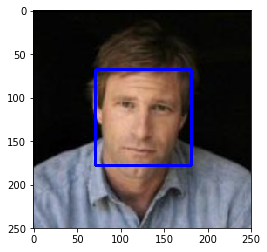

In [14]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [15]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [16]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

i,j=0,0

for k in range(100):
    if(face_detector(human_files_short[k])):
        i=i+1
    if(face_detector(dog_files_short[k])):
        j=j+1    

print((i/100)*100)
print((j/100)*100)


96.0
18.0


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [17]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

print(use_cuda)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

True


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [18]:

def VGG16_predict(image_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    # Turn the input into a Variable
    if use_cuda:
        image = Variable(image_tensor.cuda())
    
    VGG16.eval()
    # Predict the class of the image
    output = VGG16(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [20]:

def dog_detector(img_path):
    '''
    Use pre-trained VGG-16 model to check if the image 
    contains a dog or not
    
    Args:
        img_path: path to an image
        
    Returns:
        returns "True" if a dog is detected in the image stored at img_path
    '''    
    class_id = VGG16_predict(img_path)
    if(class_id > 150 and class_id < 269):
        return True
    else: 
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [21]:

### Testing the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detector_v = np.vectorize(dog_detector)

human_detected_dog = dog_detector_v(human_files_short)
dog_detected = dog_detector_v(dog_files_short)

print("Percentage of dogs detected in humans dataset is",human_detected_dog.mean()*100,"%")
print("Percentage of dogs detected in dogs dataset is",dog_detected.mean()*100,"%")


Percentage of dogs detected in humans dataset is 0.0 %
Percentage of dogs detected in dogs dataset is 91.0 %


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [22]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


data_dir = '/MOOCs/Udacity/DeepLearningNanoDegree/DataSet/dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [24]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_transforms = {
    'train' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [25]:

image_datasets = {
    'train' : ImageFolder(root=train_dir,transform=data_transforms['train']),
    'valid' : ImageFolder(root=valid_dir,transform=data_transforms['valid']),
    'test' : ImageFolder(root=test_dir,transform=data_transforms['test']),
}

In [26]:

data_loaders = {
    'train' : DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),
    'valid' : DataLoader(image_datasets['valid'],batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'],batch_size = batch_size)    
}

In [28]:
print("Size of training set is: "+str(len(image_datasets['train'])))
print("Size of validation set is: "+str(len(image_datasets['valid'])))
print("Size of testing set is: "+str(len(image_datasets['test'])))
print("Number of classes are: "+str(len(image_datasets['train'].classes)))

Size of training set is: 6680
Size of validation set is: 835
Size of testing set is: 836
Number of classes are: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

(1) For train images resize factor has been takedn as 224 as described in Alexnet paper. RandomHorizonral flip and Random   rotation with 10 degree has been choosen to make data more generalize. And noramlization has been done , to bring image on same scale.. Normalization helps CNN perform better.Normalization helps get data within a range and reduces the skewness which helps learn faster and better

(2) Yes, training data has been augmented.  RandomHorizonral flip , random rotation , random crop and noramlization has been use to make it more gereneralize.



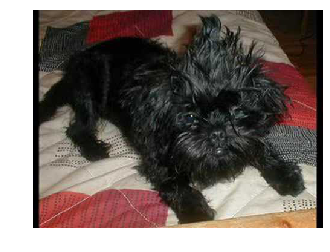

In [33]:
## To do
##Try to visualize data before starting with the CNN architecture
plt.axis('off')
plt.imshow(plt.imread(image_datasets['train'].imgs[1][0]))

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [34]:
# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)

        self.fc1 = nn.Linear(256 * 6 * 6, 133)
        
        self.max_pool = nn.MaxPool2d(2, 2,ceil_mode=True)
        self.dropout = nn.Dropout(0.2)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.conv_bn2(x)
        
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.conv_bn3(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = self.conv_bn4(x)
        
        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.conv_bn5(x)
        
        x = F.relu(self.conv5(x))
        x = self.max_pool(x)
        x = self.conv_bn6(x)
        
        x = x.view(-1, 256 * 6 * 6)
        
        x = self.dropout(x)
        x = self.fc1(x)


        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [35]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=133, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (dropout): Dropout(p=0.2)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6): BatchNorm2d(256, eps=1e-05,

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

In total  six convolution layers have been used by me starting with 16,32,64,128,256 size. This choise has been made after going thorugh various literature and blogs. For activation function relu has been used , which is widely used activation function. Max pooling layers of 2*2 have been used.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [36]:
# specify loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [41]:
def train(n_epochs, loaders, model, optimizer,scheduler, criterion, use_cuda, save_path):
    '''
    trains the model according to given parameters
    
    Args:
        n_epochs: Number of epochs
        loaders: data loaders
        model: model to be trained
        optimizer: optimizer needed to train the model
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        save_path: path to save the model 
        
    Returns:
        returns trained model
    '''  
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    print("Using Cude : ",use_cuda)
    
    for epoch in range(1, n_epochs+1):
        print("epoch : ",epoch)
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        scheduler.step()
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


        # calculate average losses
        train_loss = train_loss/len(loaders_scratch['train'].dataset)
        valid_loss = valid_loss/len(loaders_scratch['valid'].dataset)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
    return model

In [40]:
print(len(loaders_scratch['valid'].dataset))
print(use_cuda)

835
True


In [42]:
# train the model
loaders_scratch = data_loaders
n_epochs = 20


#model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch,exp_lr_scheduler, 
                      #criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Using Cude :  True
epoch :  1
Epoch: 1 	Training Loss: 0.000598 	Validation Loss: 0.004883
Validation loss decreased (inf --> 0.004883).  Saving model ...
epoch :  2
Epoch: 2 	Training Loss: 0.000494 	Validation Loss: 0.004713
Validation loss decreased (0.004883 --> 0.004713).  Saving model ...
epoch :  3
Epoch: 3 	Training Loss: 0.000403 	Validation Loss: 0.004643
Validation loss decreased (0.004713 --> 0.004643).  Saving model ...
epoch :  4
Epoch: 4 	Training Loss: 0.000325 	Validation Loss: 0.004787
epoch :  5
Epoch: 5 	Training Loss: 0.000260 	Validation Loss: 0.005010
epoch :  6
Epoch: 6 	Training Loss: 0.000205 	Validation Loss: 0.005131
epoch :  7
Epoch: 7 	Training Loss: 0.000127 	Validation Loss: 0.004877
epoch :  8
Epoch: 8 	Training Loss: 0.000105 	Validation Loss: 0.004804
epoch :  9
Epoch: 9 	Training Loss: 0.000096 	Validation Loss: 0.004838
epoch :  10
Epoch: 10 	Training Loss: 0.000085 	Validation Loss: 0.004868
epoch :  11
Epoch: 11 	Training Loss: 0.000078 	Validatio

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [43]:

def test(loaders, model, criterion, use_cuda):
    '''
    trains the model according to given parameters
    
    Args:
        loaders: data loaders
        model: model to be trained
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        
    Returns:
        print test loss and test accuracy
    '''  

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [44]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.825750


Test Accuracy: 15% (130/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
import os
print(os.listdir("/MOOCs/Udacity/DeepLearningNanoDegree/DataSet/dogImages/"))

['test', 'train', 'valid']


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [51]:
model_transfer = models.resnet18(pretrained=True)
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [52]:
for param in model_transfer.parameters():
    param.requires_grad = False


num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, 133)

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I knew resnet and vgg16 . So I tried both and got good results from resnet. The same has been used in many research papers.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [53]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [55]:
loaders_transfer = data_loaders
n_epochs = 20
# train the model
train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, exp_lr_scheduler,criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Using Cude :  True
epoch :  1
Epoch: 1 	Training Loss: 0.000389 	Validation Loss: 0.001519
Validation loss decreased (inf --> 0.001519).  Saving model ...
epoch :  2
Epoch: 2 	Training Loss: 0.000160 	Validation Loss: 0.001058
Validation loss decreased (0.001519 --> 0.001058).  Saving model ...
epoch :  3
Epoch: 3 	Training Loss: 0.000116 	Validation Loss: 0.000934
Validation loss decreased (0.001058 --> 0.000934).  Saving model ...
epoch :  4
Epoch: 4 	Training Loss: 0.000095 	Validation Loss: 0.000813
Validation loss decreased (0.000934 --> 0.000813).  Saving model ...
epoch :  5
Epoch: 5 	Training Loss: 0.000082 	Validation Loss: 0.000852
epoch :  6
Epoch: 6 	Training Loss: 0.000073 	Validation Loss: 0.000763
Validation loss decreased (0.000813 --> 0.000763).  Saving model ...
epoch :  7
Epoch: 7 	Training Loss: 0.000067 	Validation Loss: 0.000793
epoch :  8
Epoch: 8 	Training Loss: 0.000062 	Validation Loss: 0.000799
epoch :  9
Epoch: 9 	Training Loss: 0.000055 	Validation Loss: 0.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [57]:
def test(loaders, model, criterion, use_cuda):
    '''
    trains the model according to given parameters
    
    Args:
        loaders: data loaders
        model: model to be trained
        criterion: specify loss function (categorical cross-entropy)
        use_cuda: use GPU if available
        
    Returns:
        print test loss and test accuracy
    '''  

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [58]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.698902


Test Accuracy: 79% (668/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [66]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    '''
    Use pre-trained model to obtain dog breed name corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Breed name corresponding to model's prediction
    '''
    image = Image.open(img_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()
    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    image = Variable(image_tensor)
    # Turn the input into a Variable
    if use_cuda:
        image = Variable(image_tensor.cuda())
    
    model_transfer.eval()
    # Predict the class of the image
    output = model_transfer(image)
    output = output.cpu()
    index = output.data.numpy().argmax()

    return class_names[index]

In [70]:
predict_breed_transfer(dog_files_short[1])

'Affenpinscher'

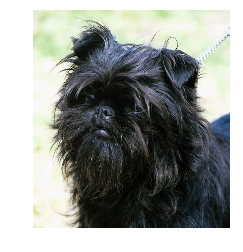

In [71]:
plt.axis('off')
plt.imshow(plt.imread(dog_files_short[1]))

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [72]:

### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    '''
    Use pre-trained model to to check if the image at the given path
    contains a human being or a dog or none. 
    
    Args:
        img_path: path to an image
        
    Returns:
        print if a human face is detected or not
        print the dog breed or show that neither human face nor a dog detected 
    '''
    plt.axis('off')
    plt.imshow(plt.imread(img_path))
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    if(is_human):
        print("Human Face detected")
        print("It looks like the dog "+predict_breed_transfer(img_path))
        return
    elif(is_dog):
        print("It looks like the dog is of breed "+predict_breed_transfer(img_path))
        return
    else:
        print("Neither a human nor a dog")
        return

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The overall performnace is satifactory . But there are scope for improvement. In one of the below example it misclassifies dog as neither.
<br>
(1) Better data . Augmentation along with , cropping the dog images could be used. This would help in noise reduction. <br>
(2) Model architecture could be improved. More reaecrh on the state of art architectures could be used.<br>
(3) Better optimization techniues could be use.

Human Face detected
It looks like the dog Silky terrier
Human Face detected
It looks like the dog American water spaniel
Neither a human nor a dog
Neither a human nor a dog
It looks like the dog is of breed Affenpinscher
It looks like the dog is of breed Affenpinscher


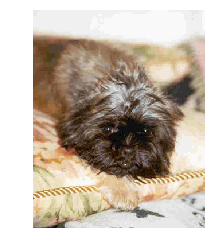

In [73]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
#for file in np.hstack((human_files[:3], dog_files[:3])):
    #run_app(file)

Human Face detected
It looks like the dog Silky terrier


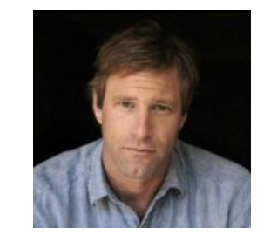

In [74]:
run_app(human_files[0])

Human Face detected
It looks like the dog American water spaniel


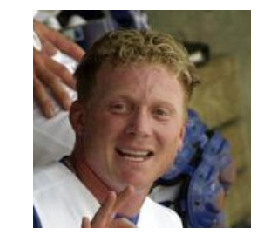

In [75]:
run_app(human_files[1])

Neither a human nor a dog


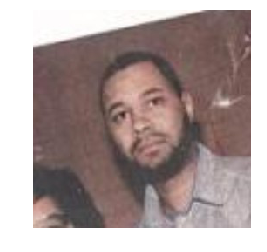

In [76]:
run_app(human_files[2])

Neither a human nor a dog


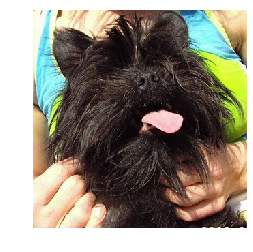

In [78]:
run_app(dog_files[0])

It looks like the dog is of breed Affenpinscher


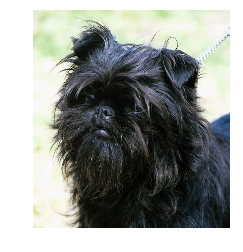

In [79]:
run_app(dog_files[1])

It looks like the dog is of breed Affenpinscher


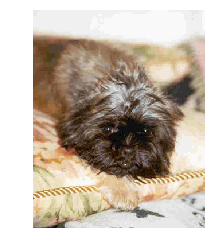

In [80]:
run_app(dog_files[2])